---
# Seq2Seq

- https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7
- https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py
- https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/
- https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://www.tensorflow.org/tutorials/text/nmt_with_attention

---



- **`encoder`: it processes the input sequence and returns its own internal state.** 

    - encoder RNN의 아웃풋은 버린다! only recovering the state.
    - This state will serve as the "context", or "conditioning"      
    
    
- **`decoder`: it is trained to predict the next characters of the target sequence, given previous characters of the target sequence.** 
    - it is trained to **turn the target sequences into the same sequences** 
    - but offset by one timestep in the future, 
    - a training process called "teacher forcing" in this context. 
    
    - `Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate.` 
    - Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import pickle
import re
import os
import io
import time
import math
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
# load
with open('dataset/desc_story_data_df.pkl', 'rb') as f:
    df_story_and_desc = pickle.load(f)

print ("before: ", df_story_and_desc.shape)
# df_story_and_desc = df_story_and_desc[:150000]

desc_story_text = df_story_and_desc[['desc', 'story']]
desc_story_text.head(15)

before:  (602325, 4)


,desc,story
0,Large tree with many outstretching branches an...,Our landmark tree in town was about to be dest...
1,A green sign is describing a historic tree and...,So we decided to take the day to go out and en...
2,A large tree with roots that look like crocodi...,"To see the final glimpse of the roots, extendi..."
3,Big old tree being photographed on a sunny day,"And its magnificent trunk, larger than life it..."
4,Huge brown tree roots rose above the ground.,One last picture of its beauty so we could cap...
5,Large tree with many outstretching branches an...,We found this tree when we were walking in a n...
6,A green sign is describing a historic tree and...,It turns out it is a popular attraction here.
7,A large tree with roots that look like crocodi...,"The tree is very unusual, with its roots exposed."
8,Big old tree being photographed on a sunny day,"The trunk was really wide, as much as 12 feet!"
9,Huge brown tree roots rose above the ground.,You can see how big these roots are - pretty a...


==> 15개 단위로 같은 사진 set에 대한 내용

In [4]:
check_sent = "Large tree with many outstretching branches and leaves."
for i, row in desc_story_text[desc_story_text['desc'] == check_sent].iterrows():
    print("pair " + str(i) + ":" + row['desc'] + " ==> " + row['story'])

pair 0:Large tree with many outstretching branches and leaves. ==> Our landmark tree in town was about to be destroyed and cleared for a new mall. 
pair 5:Large tree with many outstretching branches and leaves. ==> We found this tree when we were walking in a nearby town. 
pair 10:Large tree with many outstretching branches and leaves. ==> Pictures of a tree are taken.
pair 15:Large tree with many outstretching branches and leaves. ==> They went to the botanic gardens specifically to see the large tree.
pair 20:Large tree with many outstretching branches and leaves. ==> We went to see the largest tree in the country. 


==> 하나의 Description Text에 5개의 Story가 대응됨

## cleaning

In [5]:
def drop_duplicate(df):
    drop_df = df.drop_duplicates("desc")
    drop_df = drop_df.drop_duplicates("story")
    drop_df = drop_df.reset_index(drop=True)
    return drop_df

In [6]:
desc_story_text = drop_duplicate(desc_story_text)
desc_story_text.shape

(39771, 2)

# Prepare Data

## preprocess text

- Add a start and end token to each sentence.
- Clean the sentences by removing special characters.

In [7]:
def preprocess_sentence(w):
    w = w.lower()
    w = re.sub('[^a-zA-Z]+', ' ', w)
    w = re.sub('[^a-zA-Z.,!?]+', ' ', w)
    w = w.strip()
    
    # adding a start and an end token to the sentence
    w = '<start> ' + w + ' <end>'
    return w

In [8]:
clean_data = desc_story_text.copy()
clean_data['desc'] = desc_story_text['desc'].apply(lambda x: preprocess_sentence(x))
clean_data['story'] = desc_story_text['story'].apply(lambda x: preprocess_sentence(x))
clean_data.columns = ['in_desc','out_story']
clean_data

,in_desc,out_story
0,<start> large tree with many outstretching bra...,<start> our landmark tree in town was about to...
1,<start> a green sign is describing a historic ...,<start> so we decided to take the day to go ou...
2,<start> a large tree with roots that look like...,<start> to see the final glimpse of the roots ...
3,<start> big old tree being photographed on a s...,<start> and its magnificent trunk larger than ...
4,<start> huge brown tree roots rose above the g...,<start> one last picture of its beauty so we c...
...,...,...
39766,<start> an advertisement on glass for a brewin...,<start> a group of friends visited a brewery <...
39767,<start> a man holds the woman s hand under the...,<start> they were very excited <end>
39768,<start> a young man and older woman sitting do...,<start> they sampled many different beers <end>
39769,<start> an elderly couple dances outside of a ...,<start> after becoming a little buzzed they ev...


In [9]:
print(clean_data["in_desc"][0])
print(clean_data["out_story"][0])

<start> large tree with many outstretching branches and leaves <end>
<start> our landmark tree in town was about to be destroyed and cleared for a new mall <end>


## Indexing and Padding

- Create a word index and reverse word index (dictionaries mapping from word → id and id → word).   
: 단어 색인과 역방향 단어 색인을 만듭니다 (단어 → ID 및 ID → 단어에서 매핑 된 사전).

- Pad each sentence to a maximum length.

In [10]:
def tokenize(input_desc, output_story, flag):
    '''Args flags : pre / post 차이 
    '''
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    
    if flag == "input":
        tokenizer.fit_on_texts(input_desc)
        # sentence 최대 길이로 패딩 자동으로 해줌
        input_seq = tokenizer.texts_to_sequences(input_desc)
        padding_flag = 'post'
#        padding_flag = 'pre' # input은 앞에서 0을 채움
        input_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, padding=padding_flag)
        
        return input_pad_seq, tokenizer
    else:
        tokenizer.fit_on_texts(output_story)
        output_seq = tokenizer.texts_to_sequences(output_story)
        padding_flag = 'post' # output은 뒤에서 0을 채움
        output_pad_seq = tf.keras.preprocessing.sequence.pad_sequences(output_seq, padding=padding_flag)
    
        return output_pad_seq, tokenizer

In [11]:
def get_token_data(data):
    # creating cleaned input, output pairs
    input_desc, output_story = data['in_desc'], data['out_story']
    
    tokenize_input_desc, input_tokenizer = tokenize(input_desc, output_story, "input")
    tokenize_output_story, output_tokenizer= tokenize(input_desc, output_story, "output")
    
    input_desc_train, input_desc_test, output_story_train, output_story_test = train_test_split(tokenize_input_desc, tokenize_output_story, test_size=0.2)
    
    print("input_desc_train: ", input_desc_train.shape)
    print("input_desc_test: ", input_desc_test.shape)
    print("output_story_train: ", output_story_train.shape)
    print("output_story_test: ", output_story_test.shape)
    
    return input_desc_train, input_desc_test, output_story_train, output_story_test, input_tokenizer, output_tokenizer

In [12]:
# Creating training and validation sets using an 80-20 split

input_desc_train, input_desc_test, output_story_train, output_story_test, input_tokenizer, output_tokenizer = get_token_data(clean_data)

input_desc_train:  (31816, 72)
input_desc_test:  (7955, 72)
output_story_train:  (31816, 77)
output_story_test:  (7955, 77)


In [13]:
input_desc_train

array([[   2,   18,   30, ...,    0,    0,    0],
       [   2,    1,   69, ...,    0,    0,    0],
       [   2,  164, 1313, ...,    0,    0,    0],
       ...,
       [   2,    1,   58, ...,    0,    0,    0],
       [   2,    1,   16, ...,    0,    0,    0],
       [   2,    1,   25, ...,    0,    0,    0]])

In [14]:
output_story_train

array([[   1,   83, 2101, ...,    0,    0,    0],
       [   1,  526,    9, ...,    0,    0,    0],
       [   1,    3, 2050, ...,    0,    0,    0],
       ...,
       [   1,    3, 1038, ...,    0,    0,    0],
       [   1,   25,    3, ...,    0,    0,    0],
       [   1,  450, 3504, ...,    0,    0,    0]])

In [15]:
# Calculate max_length of the target tensors
max_length_story, max_length_desc = output_story_train.shape[1], input_desc_train.shape[1]

In [16]:
# 배치 단위가 0으로 떨어지게끔 최소공약수 계산해서 배치 설정 숫자 구함

def get_divisor(num):
    divisors = []
    length = int(math.sqrt(num)) + 1
    for i in range(1, length):
        if num % i == 0:
            divisors.append(i)
            divisors.append(num // i) # 나누기 연산 후 정수부분만 구하기,

    divisors.sort()

    return divisors

get_divisor(len(input_desc_train))

[1, 2, 4, 8, 41, 82, 97, 164, 194, 328, 388, 776, 3977, 7954, 15908, 31816]

In [17]:
BUFFER_SIZE = len(input_desc_train)
BATCH_SIZE = 164
steps_per_epoch = len(input_desc_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(output_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_desc_train, output_story_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
vocab_inp_size, vocab_tar_size

(13341, 14192)

In [19]:
# Prepare training data

# prefetch = gpu에 올라갈 데이터 slices
train_ds = tf.data.Dataset.from_tensor_slices((input_desc_train, output_story_train)).shuffle(len(input_desc_train)).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((input_desc_test, output_story_test)).batch(1) # 하나씩 출력하기 위해서 batch 1

In [20]:
example_input_batch, example_target_batch = next(iter(train_ds))
example_input_batch.shape, example_target_batch.shape

(TensorShape([164, 72]), TensorShape([164, 77]))

# Write the encoder and decoder model with attention

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

**Reference**
- https://www.tensorflow.org/tutorials/text/nmt_with_attention
- https://heung-bae-lee.github.io/2020/01/22/deep_learning_11/

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,  # output을 3차원으로 반환 (batch, sequence_length, #units)
                                       return_state=True, # returns the hidden state output and cell state for the last input time step
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (164, 72, 1024)
Encoder Hidden state shape: (batch size, units) (164, 1024)


---
바다나우 어텐션 설명 참고

https://www.youtube.com/watch?v=WsQLdu2JMgI

<img src="imgs/bahdanauAttention.png" width="700" align='center'>

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # time step 별 hidden state
        self.W2 = tf.keras.layers.Dense(units) # decoder hidden state 
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1) # expand_dims를 통해 encoder의 hidden state들을 합쳐줌

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values))) #FC(tanh(FC(h1,h2,h3)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [24]:
# test
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (164, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (164, 72, 1)


In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output) 

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (164, 14192)


In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Training

In [29]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([output_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [30]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4453
Epoch 1 Batch 100 Loss 0.9004
Epoch 1 Loss 0.8816
Time taken for 1 epoch 5459.4469385147095 sec

Epoch 2 Batch 0 Loss 0.7949
Epoch 2 Batch 100 Loss 0.7523
Epoch 2 Loss 0.7737
Time taken for 1 epoch 5795.9613926410675 sec

Epoch 3 Batch 0 Loss 0.7723
Epoch 3 Batch 100 Loss 0.7081
Epoch 3 Loss 0.7195
Time taken for 1 epoch 6183.159811735153 sec

Epoch 4 Batch 0 Loss 0.7033
Epoch 4 Batch 100 Loss 0.6740
Epoch 4 Loss 0.6842
Time taken for 1 epoch 6078.722980260849 sec

Epoch 5 Batch 0 Loss 0.6144
Epoch 5 Batch 100 Loss 0.6647
Epoch 5 Loss 0.6571
Time taken for 1 epoch 6152.46605014801 sec

Epoch 6 Batch 0 Loss 0.6154
Epoch 6 Batch 100 Loss 0.6473
Epoch 6 Loss 0.6324
Time taken for 1 epoch 6100.823043346405 sec

Epoch 7 Batch 0 Loss 0.5947
Epoch 7 Batch 100 Loss 0.6144
Epoch 7 Loss 0.6102
Time taken for 1 epoch 6099.277186155319 sec

Epoch 8 Batch 0 Loss 0.6021
Epoch 8 Batch 100 Loss 0.6091
Epoch 8 Loss 0.5892
Time taken for 1 epoch 6139.639679670334 sec

Epoch 9

# Generate

In [35]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_story, max_length_desc))

    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_desc,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_story):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += output_tokenizer.index_word[predicted_id] + ' '

        if output_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [40]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def generate(sentence):
    result , sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [41]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> an empty road that does not have any cars <end>
Predicted translation: the hotel was beautifully constructed and clean <end> 


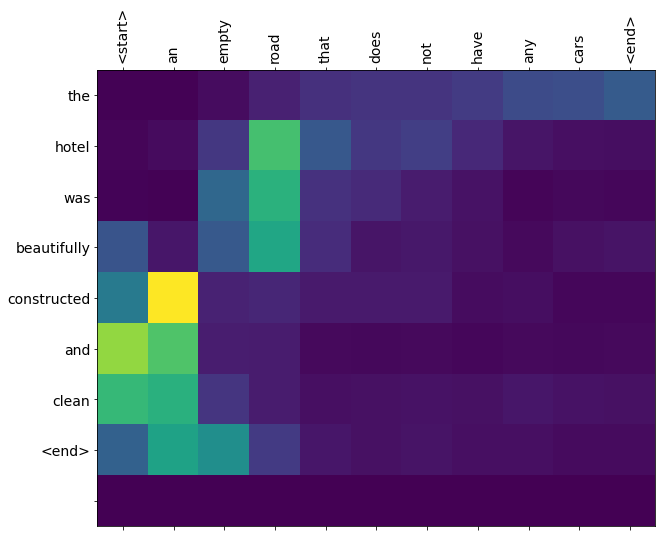

Input: <start> the men are gathered around for the picture <end>
Predicted translation: the friends talked about the people <end> 


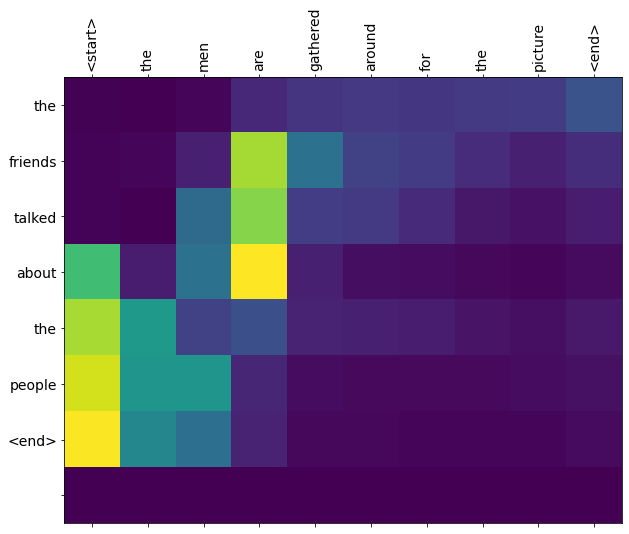

Input: <start> view of open hymn book inside a very large cathedral <end>
Predicted translation: the park was auctioned off <end> 


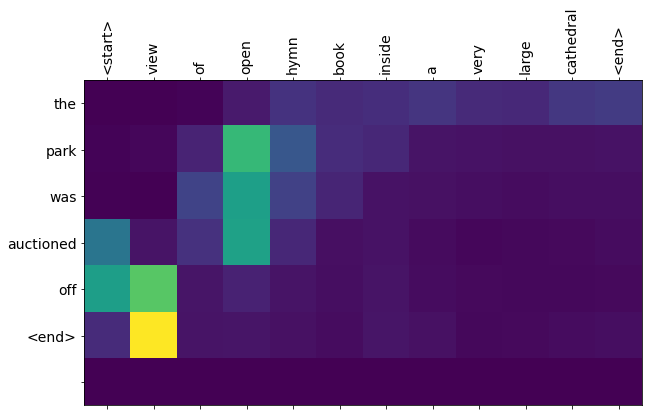

Input: <start> males smiling at camera man in middle wearing white tank top <end>
Predicted translation: i had a party <end> 


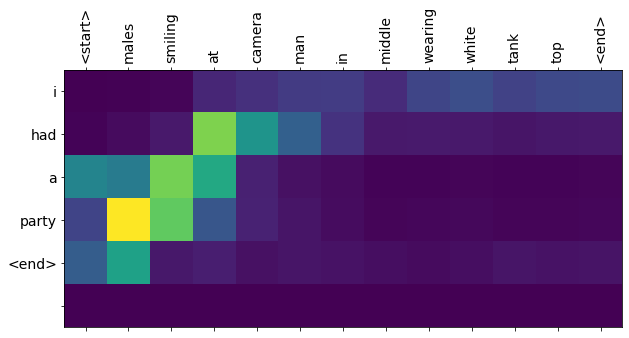

Input: <start> several women hold onto a sign for a parade as a frog walks alongside <end>
Predicted translation: the family and i went to the end of the race <end> 


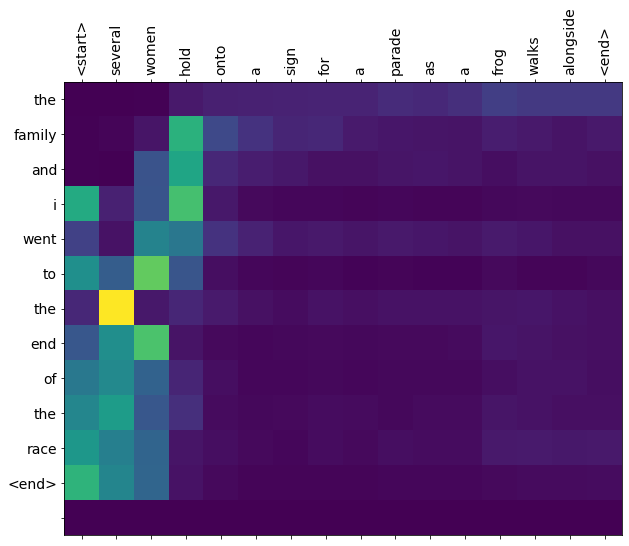

Input: <start> a guy in red black and white is wheeling his bike up <end>
Predicted translation: the parade was about to begin their team <end> 


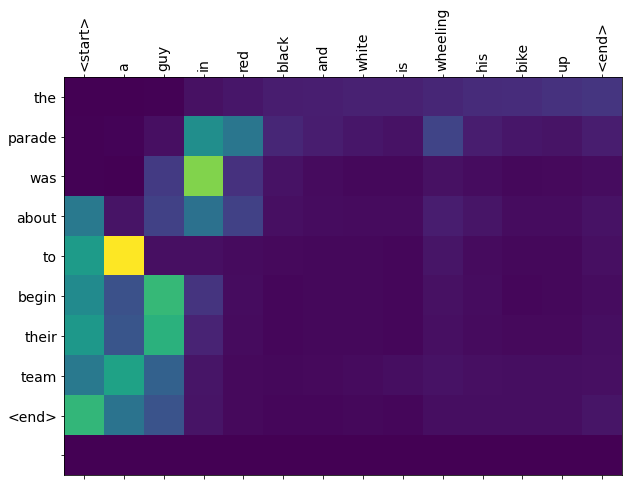

Input: <start> a cross is a very large monument at the grave yard <end>
Predicted translation: the grounds were a sight <end> 


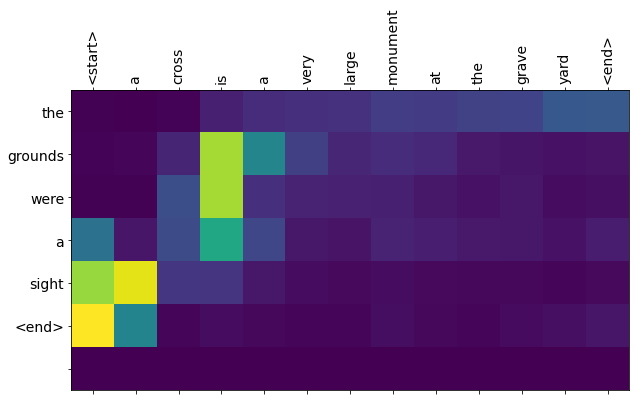

Input: <start> an artistic structure that is in a building <end>
Predicted translation: the grounds were amazing <end> 


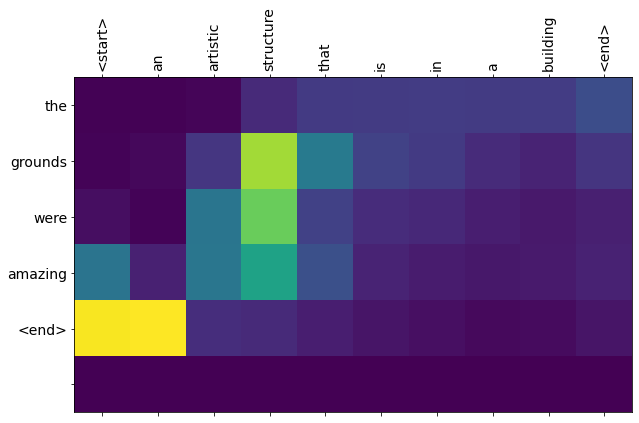

Input: <start> the woman wearing a blue shirt posed with the university of florida mascot <end>
Predicted translation: the rest of the day was the highlight of the night <end> 


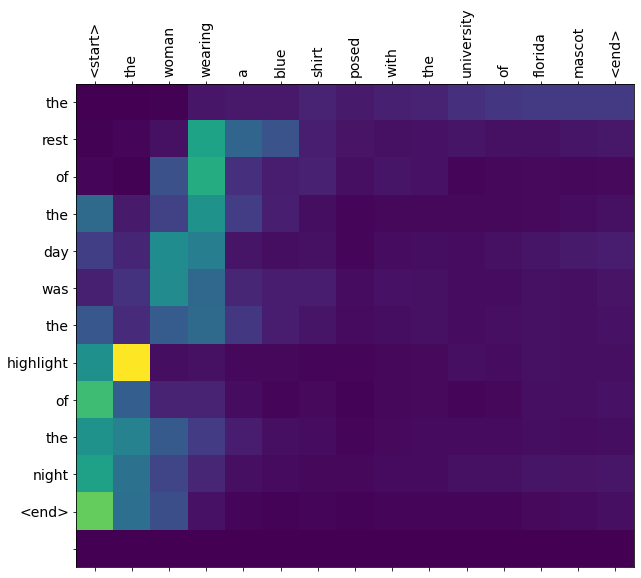

Input: <start> a beautifully ornate church on a beautiful day <end>
Predicted translation: i also saw a castle that we saw beautiful flowers <end> 


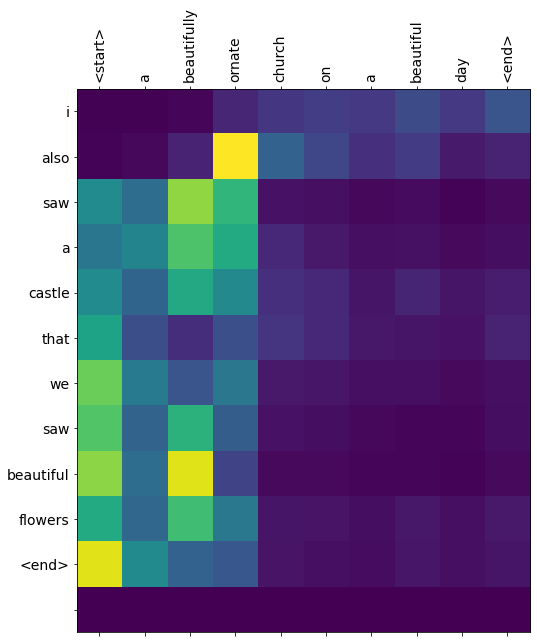

Input: <start> four men stand outside a run down building without noticing the medical assistance poster on the light post <end>
Predicted translation: we went to the beach i m stuck in the woods <end> 


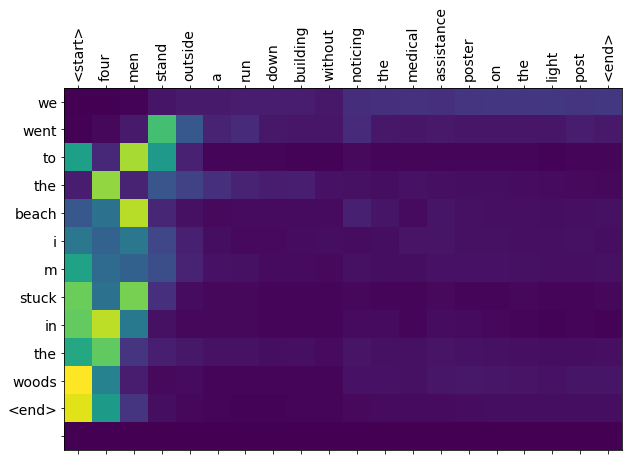

Input: <start> two little girls play on a sandy hill <end>
Predicted translation: we got to go to the beach <end> 


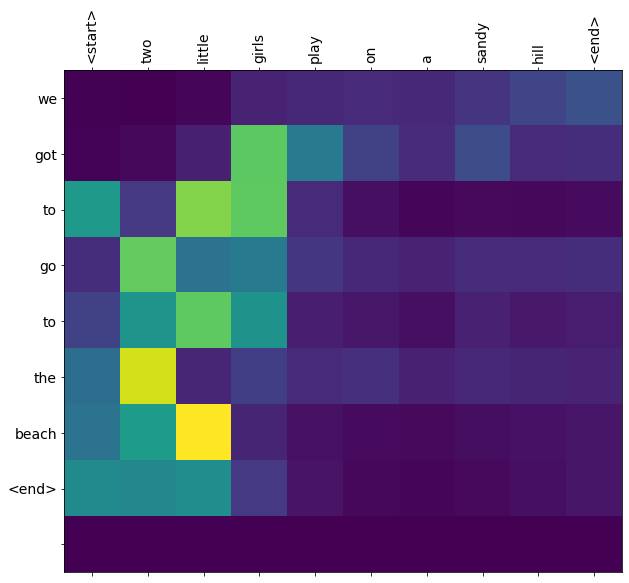

Input: <start> three men stand on a patio with drinks in their hands <end>
Predicted translation: the guys were all very happy <end> 


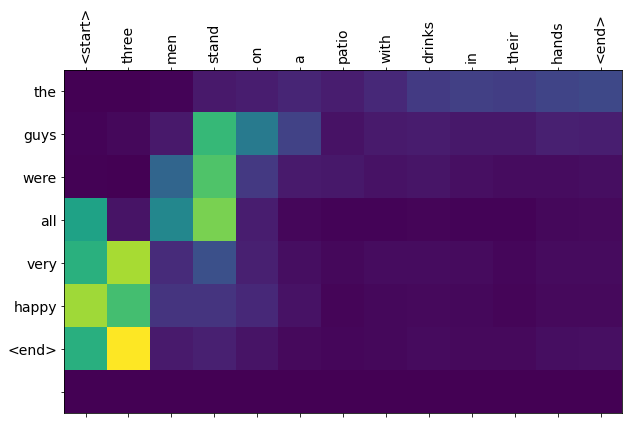

Input: <start> a group of musicians that are getting ready for an event <end>
Predicted translation: the band was obstensibly christian and the crows enters the band played songs <end> 


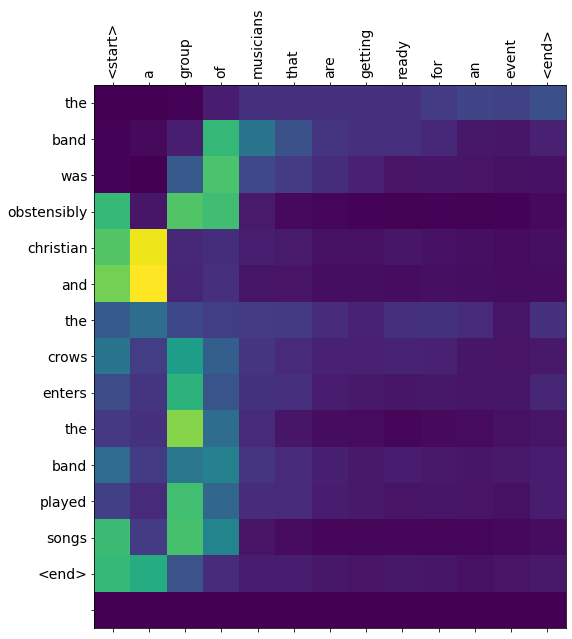

Input: <start> this room has windows but is dark inside and packed with antique furniture <end>
Predicted translation: the rooms were very creative with beautiful clothing to eat <end> 


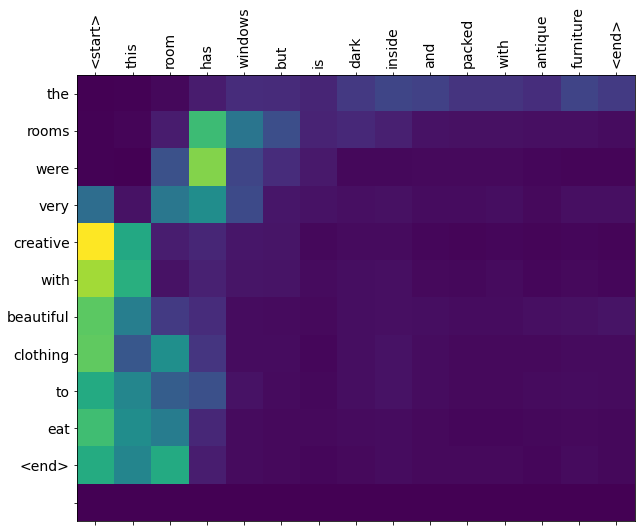

Input: <start> a gravestone with a large tree in the background <end>
Predicted translation: i love to live <end> 


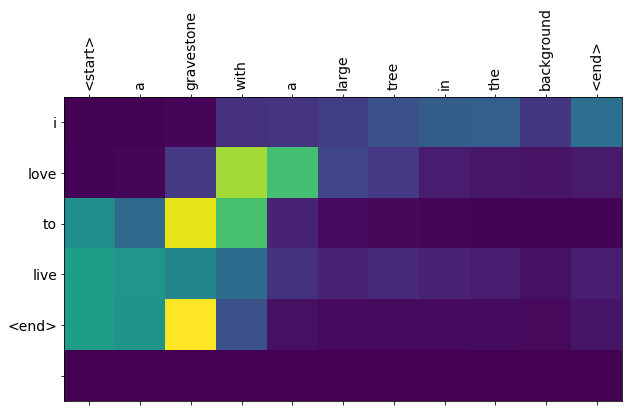

Input: <start> a strange colorful box with gears is being held out for view <end>
Predicted translation: i was really happy to the finish line for the race <end> 


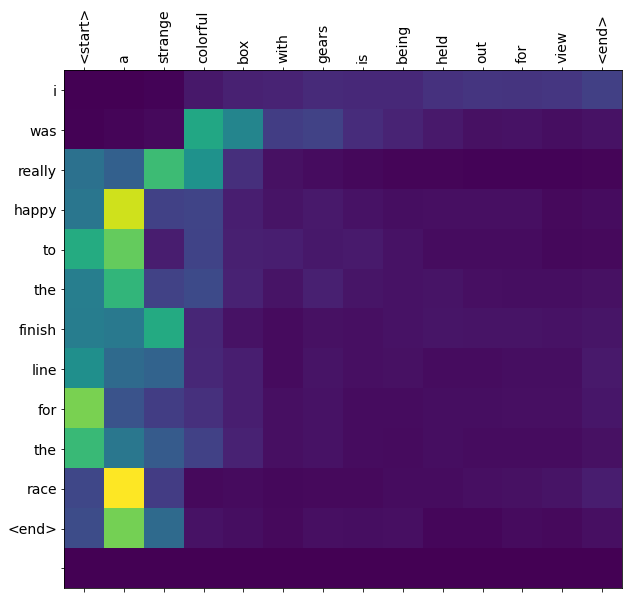

Input: <start> an award is being presented in front of a crowd <end>
Predicted translation: the audience listened intently <end> 


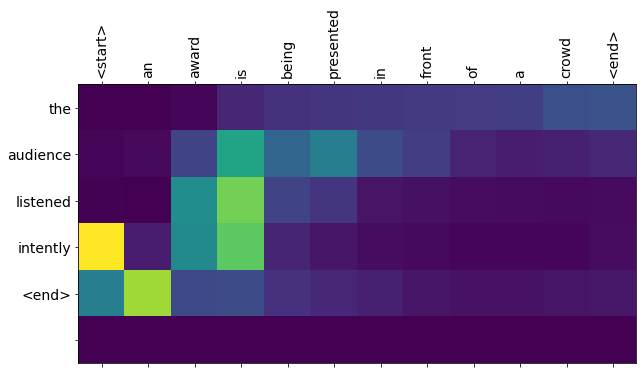

Input: <start> the crop circle had very symmetrical lines and was designed perfectly <end>
Predicted translation: the pipe was lit up in the middle of the building <end> 


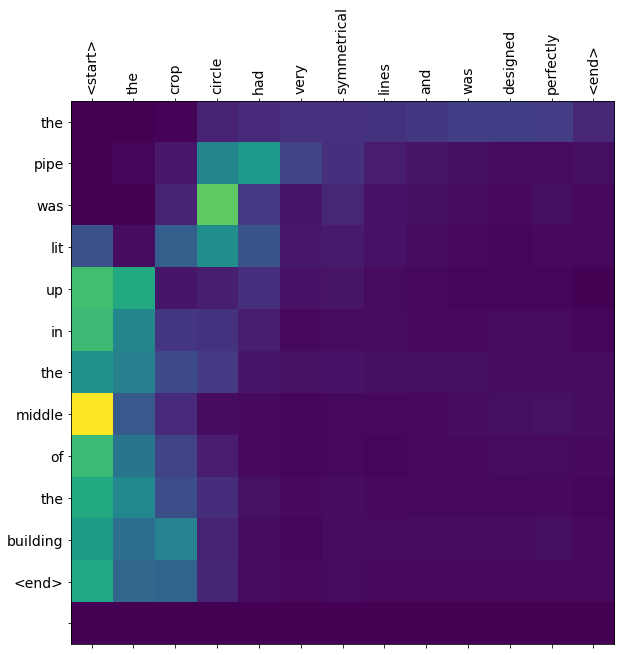

Input: <start> a horse is pulling a large cart down the street <end>
Predicted translation: i love horses and ready to get this beautiful day <end> 


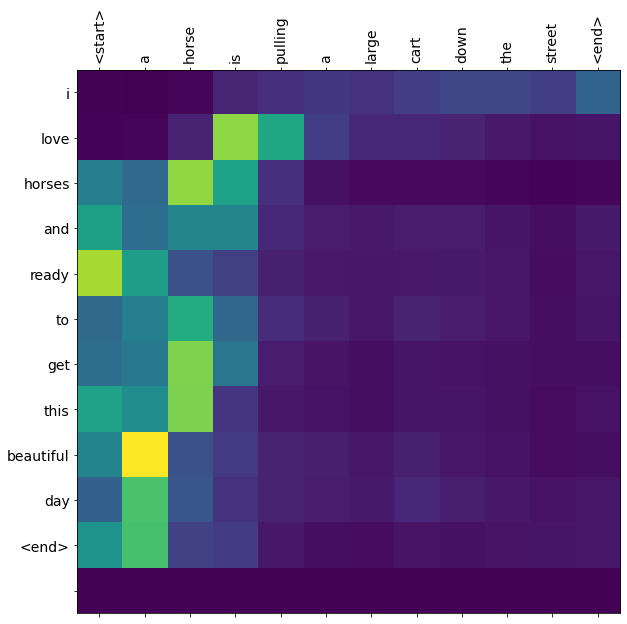

In [44]:
for i in range(20):
    random_index = random.randrange(start=0,stop=len(clean_data))
    generate(" ".join(clean_data.loc[random_index,'in_desc'].split(" ")[1:-1]))

Input: <start> large tree with many outstretching branches and leaves <end>
Predicted translation: we were all kinds of poverty and crime <end> 


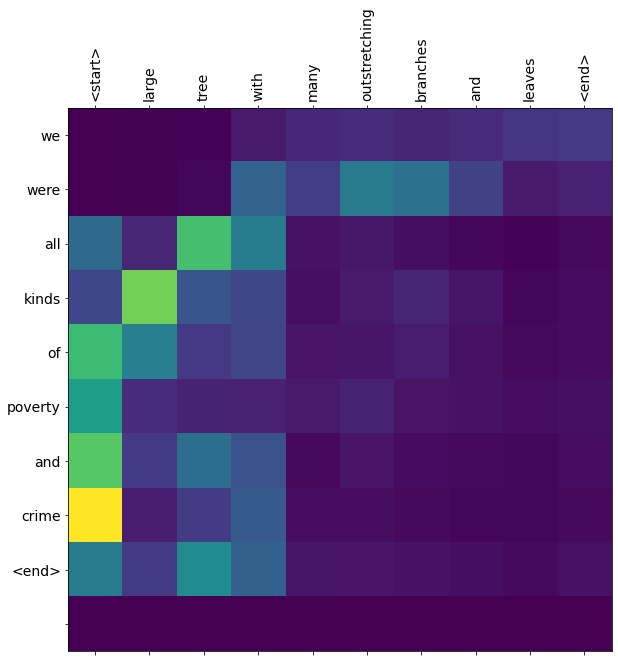

In [43]:
generate('large tree with many outstretching branches and leaves')